**Description**: Simulation check for math in [my answer on stats.stackexchange.com](https://stats.stackexchange.com/a/580894/337906) that a model can beat human labels if the labels are noisy.

**Estimated runtime**: 30 sec. to run the simulation.

**Package requirements**:
```
matplotlib==3.4.3
scikit-learn==0.24.2
tqdm==4.62.3
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm

In [2]:
# globally configure figure and font sizes to be kinda big
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [3]:
TRAIN_SIZE_MIN = 5
TRAIN_SIZE_MAX = 150
NUM_TRAIN_SIZES = 20     # num sizes to try b/t min and max sizes
NUM_EXAMPLES_TEST = 1000 # constant across simulations
NUM_SIMULATIONS = 300    # num models to fit per training size
SEED = 110963            # just the initial seed. someone's bday :-)

In [4]:
# some helpers
def sample_response(features, coef: float, noise: float, seed: int=None):
    eps = (np.random.RandomState(seed)
           .normal(scale=np.sqrt(noise), size=len(features)))
    return coef*features + eps


def sample_data(num_examples: int, coef_human: float, coef: float,
                noise_human: float, noise: float, seed_features: int=None,
                seed_eps_human: int=None, seed_eps: int=None):
    x = (np.random.RandomState(seed_features)
         # analytical result for E_D[Var(Ŷ)] assumes x has mean 0 variance 1
         .normal(loc=0, scale=1, size=num_examples))
    y_human = sample_response(x, coef_human, noise_human, seed_eps_human)
    y       = sample_response(x, coef,       noise,       seed_eps)
    return x, y_human, y


def nan_array(shape: tuple):
    a = np.empty(shape)
    a[:] = np.NaN
    return a


# main fxns
def simulate(train_sizes, coef_human: float, coef: float, noise_human: float,
             noise: float):
    '''
    Returns two 2d arrays:
    * `mses_human[i,j]` is the estimated MSE of human labels,
    `coef_human*feature + noise_human`, in simulation `j`.
    * `mses_model[i,j]` is the estimated MSE of a 0-intercept linear regression
    trained on `train_sizes[i]` examples of human labels in simulation `j`.
    '''
    mses_human = nan_array((len(train_sizes), NUM_SIMULATIONS))
    mses_model = nan_array((len(train_sizes), NUM_SIMULATIONS))
    for i, n_tr in tqdm(enumerate(train_sizes), total=len(train_sizes),
                        desc='Running simulation'):
        for j in range(NUM_SIMULATIONS):
            seed_base = SEED + i + j
            x, y_human, y = sample_data(n_tr + NUM_EXAMPLES_TEST,
                                        coef_human,
                                        coef,
                                        noise_human,
                                        noise,
                                        seed_base*1,
                                        seed_base*2,
                                        seed_base*3)
            _split_arrays = train_test_split(x, y_human, y,
                                             test_size=NUM_EXAMPLES_TEST,
                                             random_state=seed_base*4)
            x_tr, x_te, y_human_tr, y_human_te, _, y_te = _split_arrays
            y_model_te = (LinearRegression(fit_intercept=False)
                          # math assumes no intercept for simplicity
                          .fit(x_tr.reshape(-1, 1), y_human_tr)
                          .predict(x_te.reshape(-1, 1)))
            mses_human[i,j] = mse(y_te, y_human_te)
            mses_model[i,j] = mse(y_te, y_model_te)
    assert np.isnan(mses_human).sum() == 0, "Ruh roh! Some human MSE's are NaN."
    assert np.isnan(mses_human).sum() == 0, "Ruh roh! Some model MSE's are NaN."
    return mses_human, mses_model


def plot_gaps(train_sizes, noise_human, mses_human, mses_model):
    '''
    Plots the observed gap between `mses_human` and `mses_model` vs. the
    expected/theoretical gap,\n
    `noise_human - (noise_human / train_sizes)`\n
    to verify that the observed and theoretical gaps match across `train_sizes`.
    '''
    # gather stats
    avg_mses_human = np.mean(mses_human, axis=1)
    avg_mses_model = np.mean(mses_model, axis=1)
    observed_mse_gaps = avg_mses_human - avg_mses_model
    expected_mse_gaps = noise_human - (noise_human / train_sizes)
    # plot
    plt.scatter(observed_mse_gaps, expected_mse_gaps)
    _min_x, _max_x = min(observed_mse_gaps), max(observed_mse_gaps)
    plt.plot([_min_x, _max_x], [_min_x, _max_x], label='observed = expected')
    plt.legend()
    plt.xlabel("estimate MSE(Y, Y') - MSE(Y, Ŷ)")
    plt.ylabel("expected MSE(Y, Y') - MSE(Y, Ŷ)")


def plot_scaling(train_sizes, mses_model):
    '''
    Plots two lines to verify that observed and theoretical scaling match:
    * `train_sizes` vs. avg `mses_model` taken across simulations (axis=1)
    * a line fit based on the theoretial 1/n scaling of MSE
    '''
    avg_mses = np.mean(mses_model, axis=1)
    train_sizes_transformed = 1 / train_sizes.reshape(-1,1)
    model = LinearRegression().fit(train_sizes_transformed, avg_mses)
    plt.plot(train_sizes, avg_mses, label='observed')
    plt.plot(train_sizes, model.predict(train_sizes_transformed),
             label='theoretical 1/n (fitted)')
    plt.xlabel('training set size')
    plt.ylabel('estimate MSE(Y, Ŷ)')
    plt.legend()

In [5]:
coef_human = 1.1
coef = 1
noise_human = 0.25
noise = 0.2

train_sizes = (np.linspace(TRAIN_SIZE_MIN, TRAIN_SIZE_MAX, num=NUM_TRAIN_SIZES)
               .astype(int))
mses_human, mses_model = simulate(train_sizes, coef_human, coef, noise_human,
                                  noise)

Running simulation: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


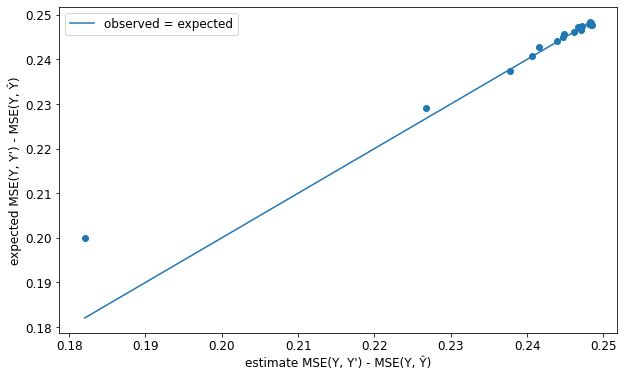

In [6]:
plot_gaps(train_sizes, noise_human, mses_human, mses_model)

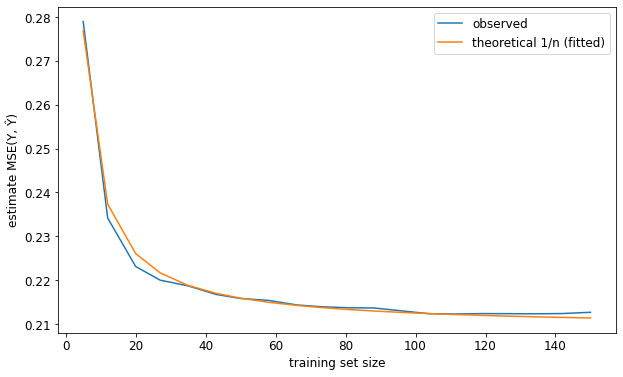

In [7]:
plot_scaling(train_sizes, mses_model)